In [1]:
import cv2
import glob
import os
import random
from skimage.feature import hog
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
images_cars = glob.glob("./dataset/vehicles/*/*.*")
images_not_cars = glob.glob("./dataset/non-vehicles/*/*.*")
random.shuffle(images_cars)
random.shuffle(images_not_cars)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


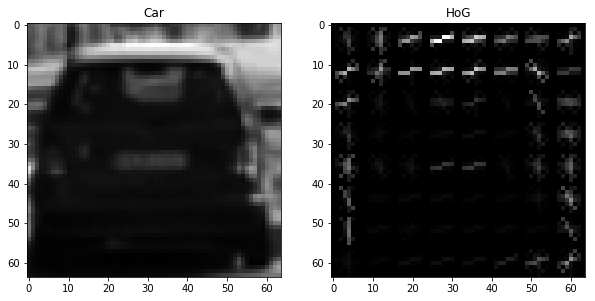

In [3]:
def get_hog_visual(input_image):
    hog_features, hog_vis = hog(input_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True, feature_vector=False, transform_sqrt=False, block_norm='L1')
    return hog_features, hog_vis

def get_hog_feature(input_image, feature_vector=True):
    return  hog(input_image, orientations=10, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=False, feature_vector=feature_vector, transform_sqrt=False, block_norm='L1')

def test_hog():
    test_image = cv2.cvtColor(mpimg.imread(images_cars[random.randint(0, len(images_cars)-1)]), cv2.COLOR_RGB2GRAY)
    hog_features, hog_vis = get_hog_visual(test_image)
    fig = plt.figure(figsize = (10,20))
    plt.subplot(121)
    plt.imshow(test_image, cmap='gray')
    plt.title('Car')
    plt.subplot(122)
    plt.imshow(hog_vis, cmap='gray')
    plt.title('HoG')
    plt.savefig('output_images/hog_vis.png', bbox_inches="tight")

test_hog()

In [4]:
def histogram(input_image):
    r_hist = np.histogram(input_image[:,:,0], bins=64, range=(0, 256))
    g_hist = np.histogram(input_image[:,:,1], bins=64, range=(0, 256))
    b_hist = np.histogram(input_image[:,:,2], bins=64, range=(0, 256))
    return np.concatenate((r_hist[0], g_hist[0], b_hist[0]))

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def extract_features_single(img, color_space, spatial_size):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = histogram(feature_image)
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_feature(feature_image[:,:,channel]))
    hog_features = np.ravel(hog_features)
    return np.concatenate((spatial_features, hist_features, hog_features))

def extract_features(images, color_space='RGB', spatial_size=(32, 32)):
    features = []
    for im_path in tqdm(images):
        img = mpimg.imread(im_path)
        feat = extract_features_single(img, color_space, spatial_size)
        features.append(feat)
    return features

In [5]:
if (not os.path.exists("./saves/features_car.npy")) or (not os.path.exists("./saves/features_not_car.npy")):
    os.mkdir("./saves")
    features_car = extract_features(images_cars, color_space='YCrCb')
    features_not_car = extract_features(images_not_cars, color_space='YCrCb')
    np.save("./saves/features_car.npy", np.array(features_car))
    np.save("./saves/features_not_car.npy", np.array(features_not_car))
else:
    features_car = np.load("./saves/features_car.npy")
    features_not_car = np.load("./saves/features_not_car.npy")

In [7]:
# Create an array stack of feature vectors

X = np.vstack((features_car, features_not_car))

# Normalize
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(features_car)), np.zeros(len(features_not_car))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=np.random.randint(0, 100))

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
print("Training SVM")
svc = LinearSVC()
svc.fit(X_train, y_train)


Feature vector length: 9144
Training SVM


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [8]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))

Test Accuracy of SVC =  98.7331


In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32)):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features_single(test_img, color_space=color_space, spatial_size=spatial_size)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


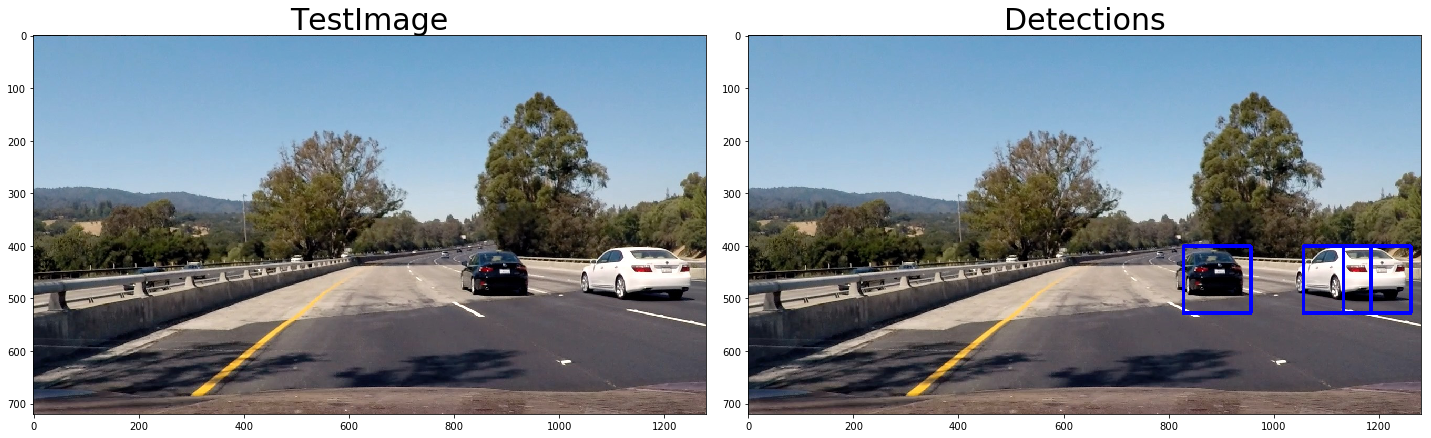

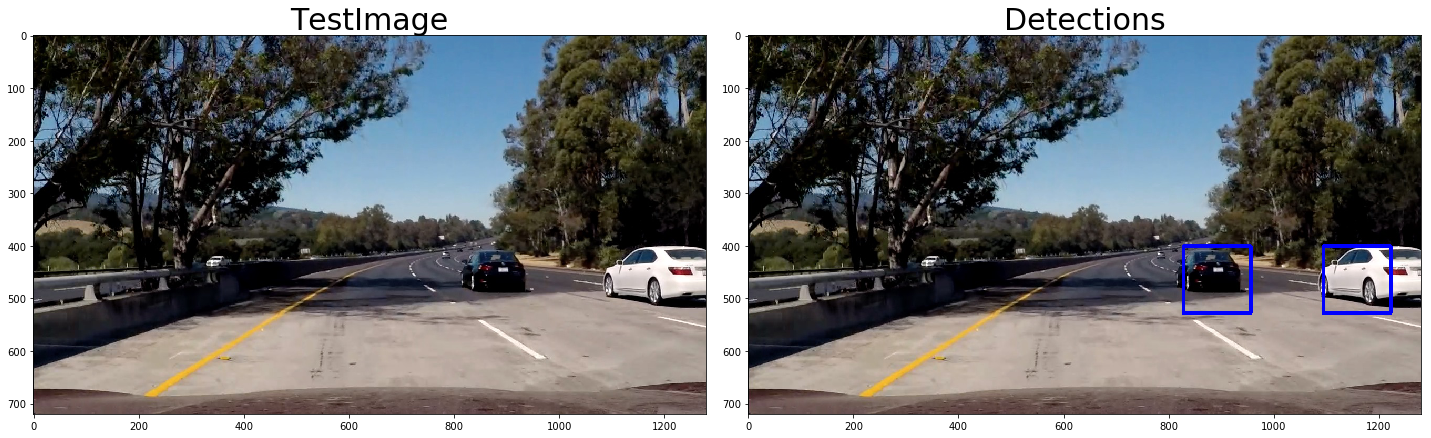

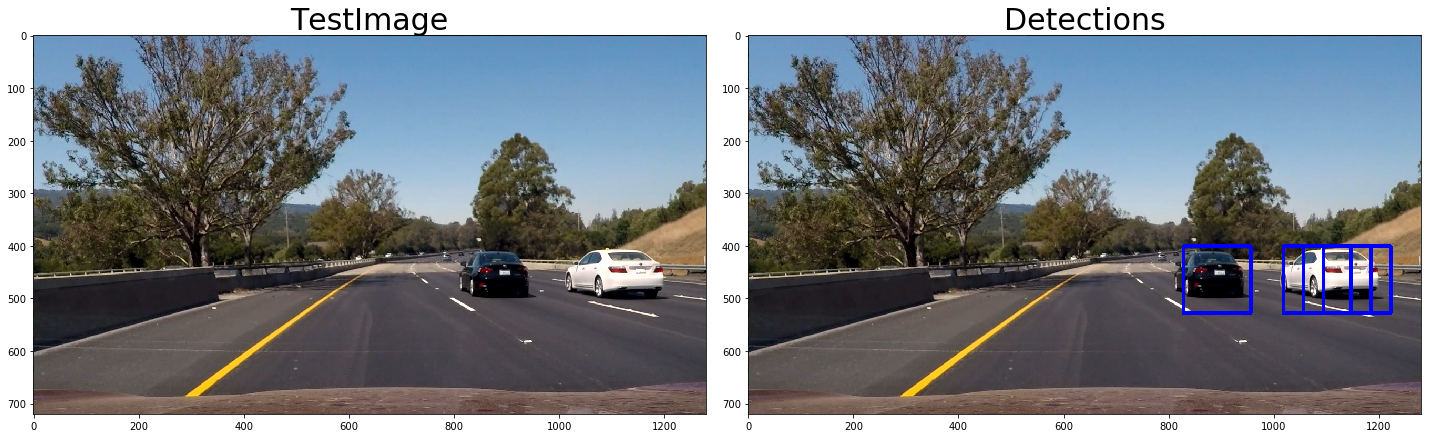

In [11]:
for i in range(4,7):
    
    test_image_path = 'test_images/test%d.jpg'%i
    test_image = mpimg.imread(test_image_path)
    draw_image = np.copy(test_image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    test_image = test_image.astype(np.float32)/255
    for scale in [1, 1.5, 2]:  
        windows =  slide_window(test_image,
                                x_start_stop=[600, None],
                                y_start_stop=[400, 700], 
                                xy_window=(int(64 * scale),int(64 * scale)),
                                xy_overlap=(.7,.7))
        detected_windows = search_windows(test_image, windows, svc, X_scaler, color_space="YCrCb")                       
        draw_image = draw_boxes(draw_image, detected_windows) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('TestImage', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Detections', fontsize=30)
    plt.savefig('output_images/windows.png', bbox_inches="tight")


In [110]:
def  add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img